In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [95]:
LOCKER_NAME = "508-1"
LOCKER_SIZE = "S"
SIZE_WITHDRAW = f"size_{LOCKER_SIZE}_withdraw"
SIZE_DELIVERY = f"size_{LOCKER_SIZE}_delivery"

# Load and parse
df = pd.read_csv(f'dataset/lockers/{LOCKER_NAME}.csv')
df['Date Hour'] = pd.to_datetime(df['Date Hour'])

# Set datetime index and resample to 3-hour intervals (keep as index for time-aware rolling)
df = df.set_index('Date Hour')
df = df.resample('3h').sum()

# Add cumulative delivery features for each size using integer windows on the 3h-resampled series.
# Use min_periods=1 so partial windows at the beginning still produce sums instead of NaN.
# size_delivery_cols = [col for col in df.columns if col.endswith('_delivery')]
# for col in size_delivery_cols:
#     df[f'{col}_last_6h'] = df[col].rolling(window=2, min_periods=1).sum()   # 6 hours = 2 * 3h
#     df[f'{col}_last_18h'] = df[col].rolling(window=6, min_periods=1).sum()  # 18 hours = 6 * 3h
#     df[f'{col}_last_1d'] = df[col].rolling(window=8, min_periods=1).sum()    # 1 day = 8 * 3h
#     df[f'{col}_last_2d'] = df[col].rolling(window=16, min_periods=1).sum()   # 2 days = 16 * 3h

# If you also want withdraw cumulative features, uncomment and adapt the following:
# size_withdraw_cols = [col for col in df.columns if col.endswith('_withdraw')]
# for col in size_withdraw_cols:
#     df[f'{col}_last_6h'] = df[col].rolling(window=2, min_periods=1).sum()
#     ...

# Optional: simple rolling aggregates for the selected size (kept for compatibility)
df[f'delivery_3h'] = df[SIZE_DELIVERY].rolling(window=1, min_periods=1).sum()
df[f'delivery_6h'] = df[SIZE_DELIVERY].rolling(window=2, min_periods=1).sum()
df[f'delivery_18h'] = df[SIZE_DELIVERY].rolling(window=6, min_periods=1).sum()
df[f'delivery_1d'] = df[SIZE_DELIVERY].rolling(window=8, min_periods=1).sum()
df[f'delivery_2d'] = df[SIZE_DELIVERY].rolling(window=16, min_periods=1).sum()

df[f'withdraw_6h'] = df[SIZE_WITHDRAW].shift(1).rolling(window=2, min_periods=1).sum()
df[f'withdraw_18h'] = df[SIZE_WITHDRAW].shift(1).rolling(window=6, min_periods=1).sum()
df[f'withdraw_1d'] = df[SIZE_WITHDRAW].shift(1).rolling(window=8, min_periods=1).sum()
df[f'withdraw_2d'] = df[SIZE_WITHDRAW].shift(1).rolling(window=16, min_periods=1).sum()


# Reset index so downstream code expecting 'Date Hour' column continues to work
df = df.reset_index()

# Fill NaNs (should be none because min_periods=1) and derive time features
df = df.fillna(0)
df['Hour'] = df['Date Hour'].dt.hour
df['Day of Week'] = df['Date Hour'].dt.dayofweek
df['Month'] = df['Date Hour'].dt.month
df['IsBusinessHour'] = df['Date Hour'].apply(lambda x: 1 if (9 <= x.hour <= 11) | (13 <= x.hour < 17) else 0)
df['IsPeakHour'] = df['Date Hour'].apply(lambda x: 1 if 17 <= x.hour <= 20 else 0)
df['IsWeekend'] = df['Date Hour'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

# Drop IsIndoor if present
if 'IsIndoor' in df.columns:
    df = df.drop(columns=['IsIndoor'])

df.head()

,Date Hour,size_L_delivery,size_M_delivery,size_S_delivery,size_XL_delivery,size_L_withdraw,size_M_withdraw,size_S_withdraw,size_XL_withdraw,delivery_3h,...,withdraw_6h,withdraw_18h,withdraw_1d,withdraw_2d,Hour,Day of Week,Month,IsBusinessHour,IsPeakHour,IsWeekend
0,2024-04-10 18:00:00,0.0,1.0,6.0,0.0,0.0,0.0,1.0,0.0,6.0,...,0.0,0.0,0.0,0.0,18,2,4,0,1,0
1,2024-04-10 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,21,2,4,0,0,0
2,2024-04-11 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0,3,4,0,0,0
3,2024-04-11 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,3,3,4,0,0,0
4,2024-04-11 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,6,3,4,0,0,0


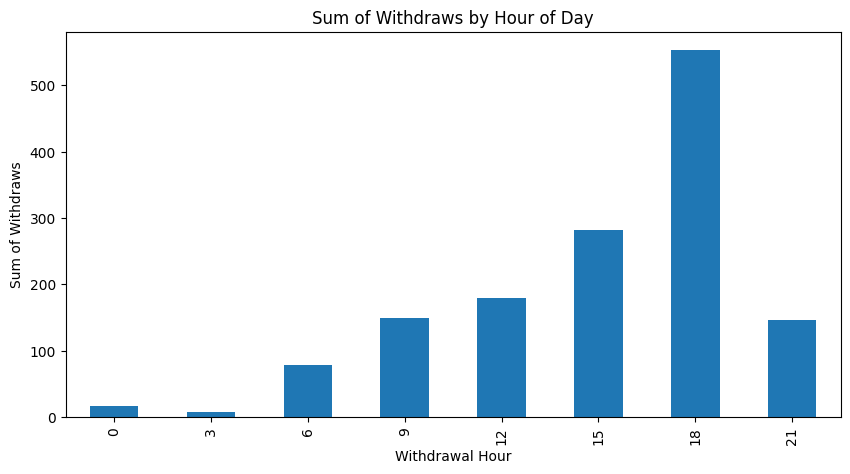

In [96]:

mean_by_hour = df.groupby('Hour')[f"size_{LOCKER_SIZE}_withdraw"].sum()
mean_by_hour.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Withdrawal Hour')
plt.ylabel('Sum of Withdraws')
plt.title('Sum of Withdraws by Hour of Day')
plt.show()

In [97]:
# variance_by_hour = df.groupby('Delivery Hour')[SIZE_FEATURE].var()
# variance_by_hour.plot(kind='bar', figsize=(10, 5))
# plt.xlabel('Delivery Hour')
# plt.ylabel('Variance of Deliveries')
# plt.title('Variance of Deliveries by Hour of Day')
# plt.show()

# Preprocessing

Enrich
1. Working hours
2. Holiday
3. Weather

Cyclical encoding

In [98]:
MONTHS_IN_YEAR = 12
HOURS_IN_DAY = 24
DAYS_IN_WEEK = 7
QUARTERS_IN_YEAR = 4

df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / HOURS_IN_DAY)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / HOURS_IN_DAY)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['Day of Week'] / DAYS_IN_WEEK)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['Day of Week'] / DAYS_IN_WEEK)

df2 = df.drop(columns=['Hour', 'Day of Week', 'Month'])
df2.head()

,Date Hour,size_L_delivery,size_M_delivery,size_S_delivery,size_XL_delivery,size_L_withdraw,size_M_withdraw,size_S_withdraw,size_XL_withdraw,delivery_3h,...,withdraw_18h,withdraw_1d,withdraw_2d,IsBusinessHour,IsPeakHour,IsWeekend,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
0,2024-04-10 18:00:00,0.0,1.0,6.0,0.0,0.0,0.0,1.0,0.0,6.0,...,0.0,0.0,0.0,0,1,0,-1.000000,-1.836970e-16,0.974928,-0.222521
1,2024-04-10 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0,0,0,-0.707107,7.071068e-01,0.974928,-0.222521
2,2024-04-11 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0,0,0,0.000000,1.000000e+00,0.433884,-0.900969
3,2024-04-11 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0,0,0,0.707107,7.071068e-01,0.433884,-0.900969
4,2024-04-11 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0,0,0,1.000000,6.123234e-17,0.433884,-0.900969


In [99]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# numerical_features = ['lag_1', 'lag_2', 'hours_since_last']
# df2[numerical_features] = scaler.fit_transform(df2[numerical_features])
# df2.head()

In [100]:
# For time-series data, use time-based split per locker instead of random
# Group by locker, sort each group by time, and split
test_size = 0.2
split_idx = int(len(df) * (1 - test_size))
train_df = df2.iloc[:split_idx]
test_df = df2.iloc[split_idx:]
DROP_SIZE_FEATURES = [col for col in df2.columns if col.endswith('_delivery') or col.endswith('_withdraw')]
X_train_ful = train_df.drop(["Date Hour"] + DROP_SIZE_FEATURES, axis=1)
y_train_ful = train_df[SIZE_WITHDRAW]
X_test = test_df.drop(["Date Hour"] + DROP_SIZE_FEATURES, axis=1)
y_test = test_df[SIZE_WITHDRAW]

# Optional: Create validation set from training data
val_size = 0.2
val_split_idx = int(len(train_df) * (1 - val_size))
X_train = X_train_ful[:val_split_idx]
y_train = y_train_ful[:val_split_idx]
X_val = X_train_ful[val_split_idx:]
y_val = y_train_ful[val_split_idx:]

print(X_train.shape, X_val.shape, X_test.shape)

(1672, 16) (419, 16) (523, 16)


In [101]:
X_train

,delivery_3h,delivery_6h,delivery_18h,delivery_1d,delivery_2d,withdraw_6h,withdraw_18h,withdraw_1d,withdraw_2d,IsBusinessHour,IsPeakHour,IsWeekend,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
0,6.0,6.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0,1,0,-1.000000e+00,-1.836970e-16,0.974928,-0.222521
1,0.0,6.0,6.0,6.0,6.0,1.0,1.0,1.0,1.0,0,0,0,-7.071068e-01,7.071068e-01,0.974928,-0.222521
2,0.0,0.0,6.0,6.0,6.0,1.0,1.0,1.0,1.0,0,0,0,0.000000e+00,1.000000e+00,0.433884,-0.900969
3,0.0,0.0,6.0,6.0,6.0,0.0,1.0,1.0,1.0,0,0,0,7.071068e-01,7.071068e-01,0.433884,-0.900969
4,0.0,0.0,6.0,6.0,6.0,0.0,1.0,1.0,1.0,0,0,0,1.000000e+00,6.123234e-17,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,0.0,0.0,14.0,14.0,14.0,1.0,1.0,1.0,2.0,0,0,0,7.071068e-01,7.071068e-01,0.781831,0.623490
1668,0.0,0.0,14.0,14.0,14.0,0.0,1.0,1.0,2.0,0,0,0,1.000000e+00,6.123234e-17,0.781831,0.623490
1669,0.0,0.0,14.0,14.0,14.0,0.0,1.0,1.0,2.0,1,0,0,7.071068e-01,-7.071068e-01,0.781831,0.623490
1670,0.0,0.0,0.0,14.0,14.0,1.0,2.0,2.0,3.0,0,0,0,1.224647e-16,-1.000000e+00,0.781831,0.623490


In [102]:
model = XGBRegressor(
    objective='count:poisson',
    random_state=42,
    early_stopping_rounds=40
)

param_grid = {
    'n_estimators': [500, 1000, 2000, 3000],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.001, 0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=False)
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


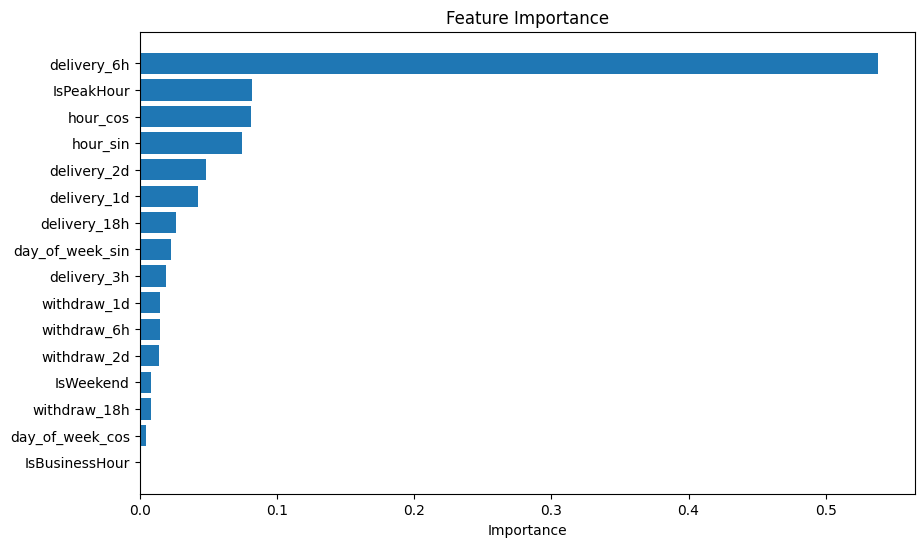

In [103]:
feature_importance = pd.DataFrame({
    'Feature': X_train_ful.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [104]:
evaluation_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Time': df2['Date Hour'].iloc[split_idx:]
})
evaluation_df.head()

,Actual,Predicted,Time
2091,0.0,0.071482,2024-12-28 03:00:00
2092,0.0,0.240927,2024-12-28 06:00:00
2093,0.0,0.437857,2024-12-28 09:00:00
2094,1.0,0.516493,2024-12-28 12:00:00
2095,0.0,0.797568,2024-12-28 15:00:00


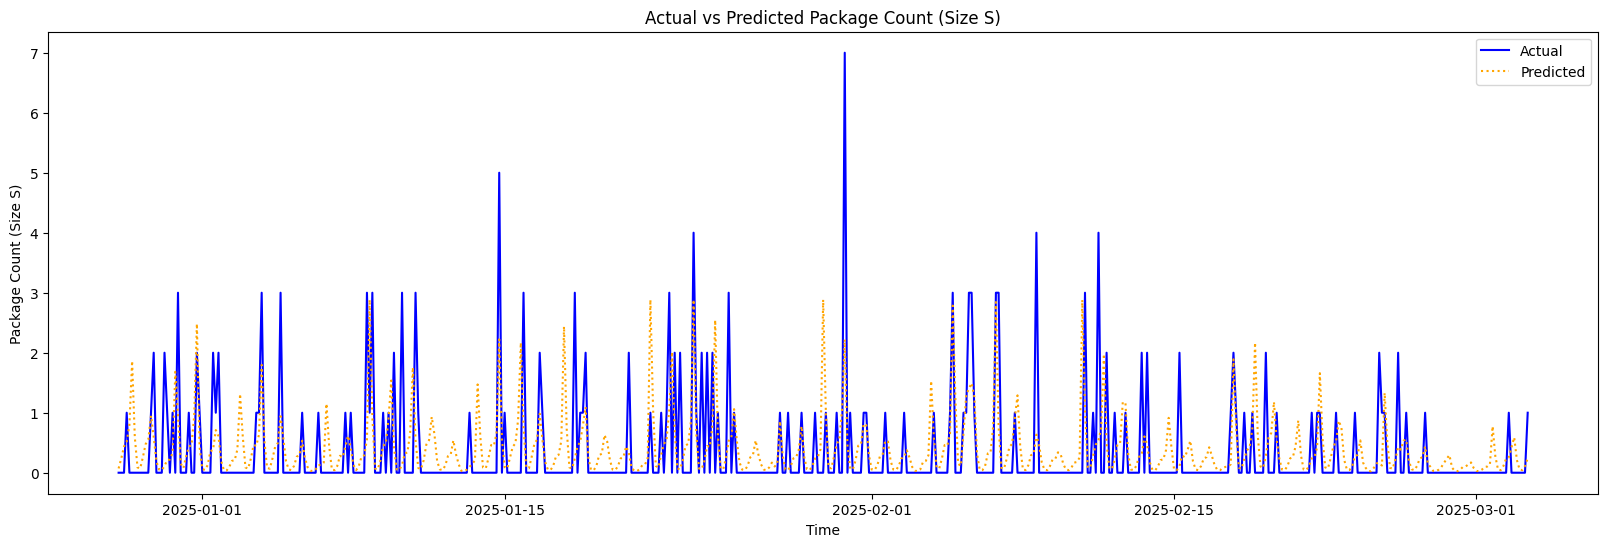

In [105]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=evaluation_df, x='Time', y='Actual', label='Actual', color='blue')
sns.lineplot(data=evaluation_df, x='Time', y='Predicted', label='Predicted', color='orange', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Package Count (Size S)')
plt.title('Actual vs Predicted Package Count (Size S)')
plt.legend()
plt.show()

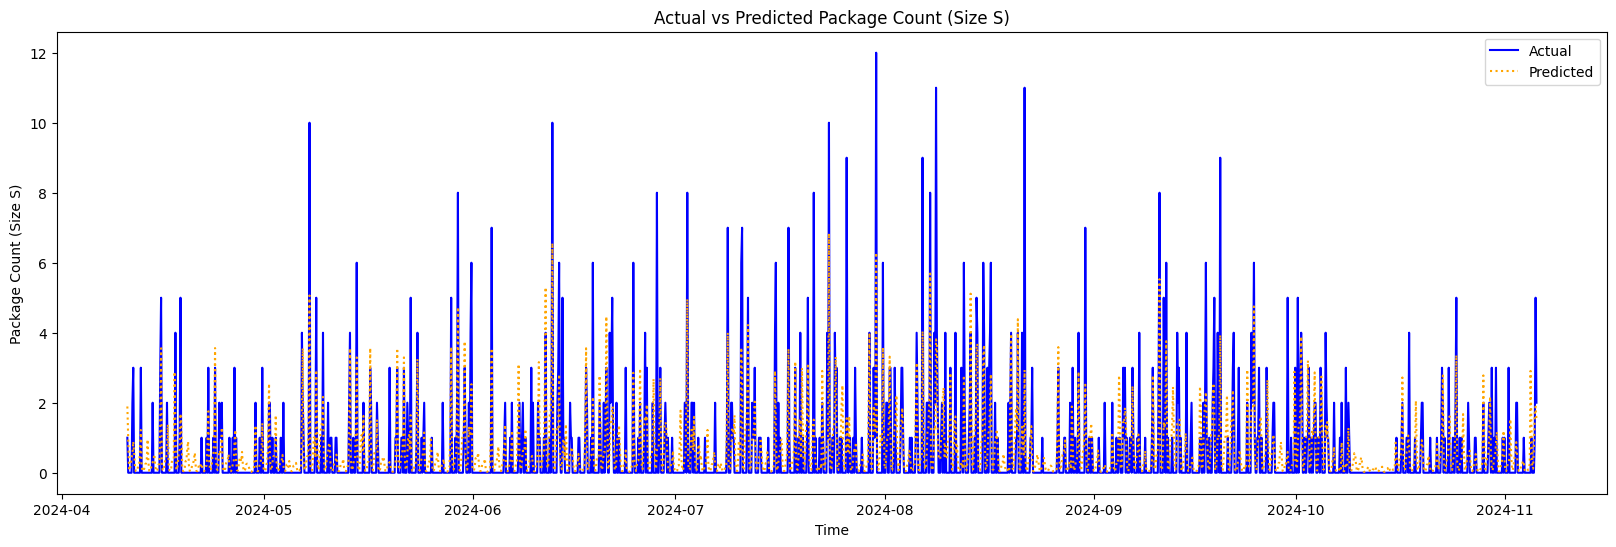

In [106]:
# Plot the predictions vs actuals
y_pred = best_model.predict(X_train)

evaluation_df = pd.DataFrame({
    'Actual': y_train,
    'Predicted': y_pred,
    'Time': df2['Date Hour'].iloc[:len(y_train)]
})

plt.figure(figsize=(20, 6))
sns.lineplot(data=evaluation_df, x='Time', y='Actual', label='Actual', color='blue')
sns.lineplot(data=evaluation_df, x='Time', y='Predicted', label='Predicted', color='orange', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Package Count (Size S)')
plt.title('Actual vs Predicted Package Count (Size S)')
plt.legend()
plt.show()

MAE: 0.573  |  RMSE: 1.004


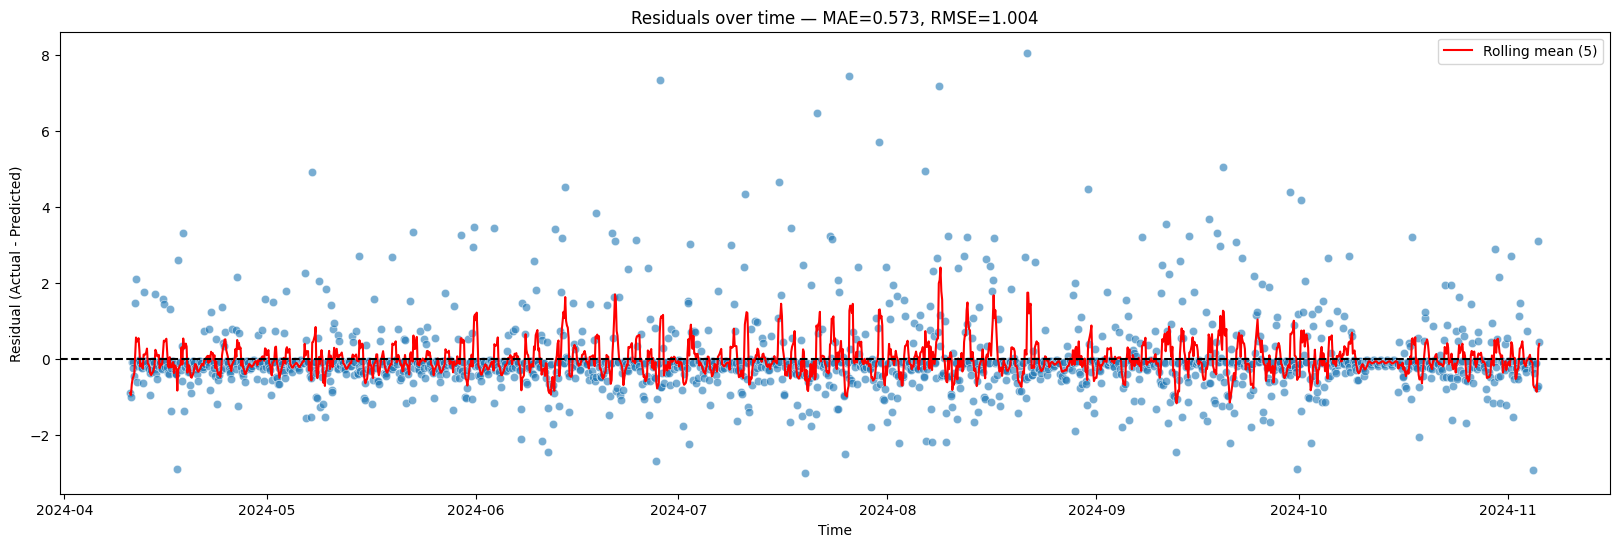

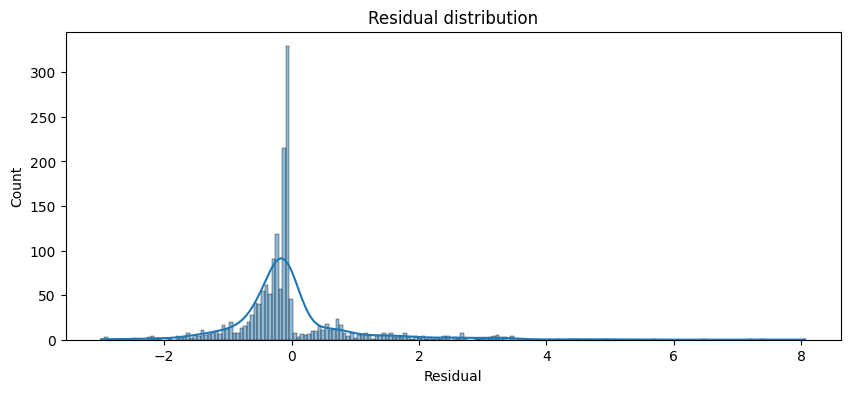

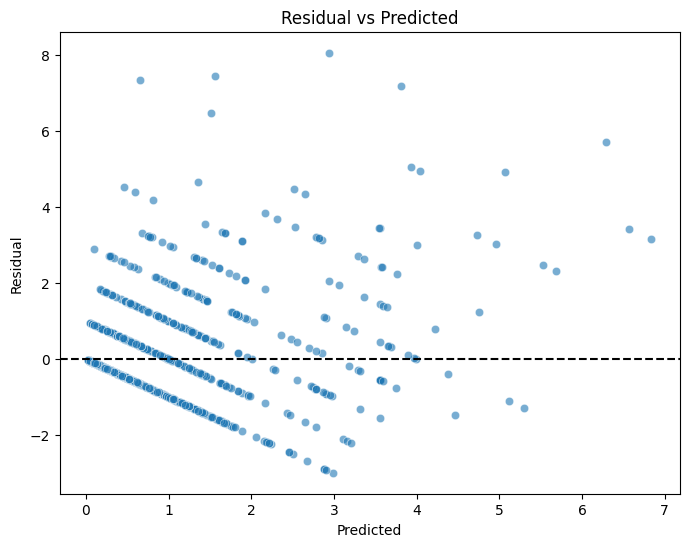

In [107]:
# Residual analysis over time
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Ensure evaluation_df exists; if not, build from y_test/y_pred and df2
try:
    _ = evaluation_df
except NameError:
    evaluation_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Time': df2['Delivery Date Hour'].iloc[split_idx:]
    })

# Compute residuals
evaluation_df['Residual'] = evaluation_df['Actual'] - evaluation_df['Predicted']
mae = mean_absolute_error(evaluation_df['Actual'], evaluation_df['Predicted'])
rmse = root_mean_squared_error(evaluation_df['Actual'], evaluation_df['Predicted'])

print(f"MAE: {mae:.3f}  |  RMSE: {rmse:.3f}")

# Plot residuals over time with rolling mean
plt.figure(figsize=(20, 6))
sns.scatterplot(data=evaluation_df, x='Time', y='Residual', alpha=0.6)
# rolling mean (window=5 points)
evaluation_df = evaluation_df.sort_values('Time')
rolling_mean = evaluation_df['Residual'].rolling(window=5, min_periods=1).mean()
sns.lineplot(x=evaluation_df['Time'], y=rolling_mean, color='red', label='Rolling mean (5)')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.title(f'Residuals over time — MAE={mae:.3f}, RMSE={rmse:.3f}')
plt.legend()
plt.show()

# Residual distribution
plt.figure(figsize=(10, 4))
sns.histplot(evaluation_df['Residual'], kde=True)
plt.title('Residual distribution')
plt.xlabel('Residual')
plt.show()

# Optional: residuals vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=evaluation_df['Predicted'], y=evaluation_df['Residual'], alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual vs Predicted')
plt.show()